<font color=red><h1> 1. Loading data and packages</h1></font>

<font color=green><h2> 1.1 Loading packages</h2></font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin import stock_info as Yinfo
from datetime import timedelta, datetime
from scipy.spatial.distance import euclidean
from tabulate import tabulate
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings('ignore')

<font color=green><h2> 1.2 Loading NASAQ Tickers</h2></font>

In [3]:
# Import all tickers for NASDAQ
Dec=True
while Dec==True:
    try:
        Dec=False
        NASDAQ=Yinfo.tickers_nasdaq()
    except:Dec=True

In [ ]:
# Large Companies have market capitalization>10 billion dollars
# Mid Companies have market capitalization between >2billion $ and <=10 billion $
Large_CAP_companies=[]
Mid_CAP_companies=[]
for i in NASDAQ:
   try:
      if yf.Ticker(i).info['quoteType'] =='EQUITY':
         Market_CAP=yf.Ticker(i).info['marketCap']
         if Market_CAP>2*1e9 and Market_CAP<=10*1e9:
            Mid_CAP_companies.append(i)
         if Market_CAP>10*1e9:
            Large_CAP_companies.append(i)
   except:pass

In [4]:
# Read the daily volume of each company
Start_date=datetime.strptime('2010-01-01', '%Y-%m-%d').date()
End_date=datetime.strptime('2011-01-01', '%Y-%m-%d').date()


Volume_LargeCap=yf.download(Large_CAP_companies,Start_date,End_date).loc[:,'Volume']
Volume_LargeCap.dropna(axis=1,inplace=True)

Volume_MidCap=yf.download(Mid_CAP_companies,Start_date,End_date).loc[:,'Volume']
Volume_MidCap.dropna(axis=1,inplace=True)

[*********************100%%**********************]  249 of 251 completed

74 Failed downloads:
['MEDP', 'APP', 'MRNA', 'CART', 'FWONA', 'WMG', 'TEAM', 'MDB', 'NTRA', 'TTD', 'CDW', 'BSY', 'ABNB', 'OKTA', 'FOXA', 'FOX', 'GFS', 'SFM', 'MNDY', 'GLPI', 'RPRX', 'DOCU', 'TPG', 'SYM', 'FTAI', 'LINE', 'FWONK', 'PDD', 'CYBR', 'RIVN', 'NTNX', 'LI', 'ZS', 'ARGX', 'FANG', 'WDAY', 'PCVX', 'AFRM', 'KSPI', 'FITBI', 'ROKU', 'ZM', 'SMMT', 'DDOG', 'DKNG', 'MBLY', 'JD', 'COIN', 'KHC', 'META', 'Z', 'CHK', 'ZG', 'FER', 'GRAB', 'DUOL', 'GEHC', 'PYPL', 'NWSA', 'TW', 'WING', 'PANW', 'BPYPP', 'CG', 'BGNE', 'ARM', 'CEG', 'CRWD', 'DASH', 'NWS', 'BNTX', 'ENPH', 'HOOD', 'ACGLO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1293858000")
[*********************100%%**********************]  464 of 465 completed

233 Failed downloads:
['AGNCN', 'TNDM', 'TLN', 'MBIN', 'FRHC', 'RXST', 'NARI', 'KYMR', 'ACVA', 'TRMD', 'CLSK', 'FIVN', 'VCTR', 'EWTX', 'IBTX', 'VCYT', 'NMRA', 'HCM', 'INTA',

In [ ]:
#Select the first 100 companies with the highest average volume: It is an indication that those assets are the most liquid

AVG_LargeCap=Volume_LargeCap.mean().sort_values(ascending=False)[:100]
AVG_MidCap=Volume_MidCap.mean().sort_values(ascending=False)[:100]

AdjClose_LargeCap=yf.download(list(AVG_LargeCap.index),Start_date,End_date).loc[:,"Adj Close"]
AdjClose_MidCap=yf.download(list(AVG_MidCap.index),Start_date,End_date).loc[:,"Adj Close"]

[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  100 of 100 completed


<font color=red><h1> 2. Euclidian distance</h1></font>

In [6]:
# Calculate the euclidian distance between two stocks


Euclidian_Large=pd.DataFrame({},index=AdjClose_LargeCap.columns,columns=AdjClose_LargeCap.columns)
Euclidian_Large[:]=+1000000
# Normalize prices
Normalized_Large=(AdjClose_LargeCap-AdjClose_LargeCap.mean())/np.std(AdjClose_LargeCap)
for i in range(AdjClose_LargeCap.shape[1]-1):
    for j in range(i+1,AdjClose_LargeCap.shape[1]):
        Euclidian_Large.iloc[i,j]=euclidean(Normalized_Large.iloc[:,i],Normalized_Large.iloc[:,j])


Euclidian_Mid=pd.DataFrame({},index=AdjClose_MidCap.columns,columns=AdjClose_MidCap.columns)
Euclidian_Mid[:]=+1000000
Normalized_Mid=(AdjClose_MidCap-AdjClose_MidCap.mean())/np.std(AdjClose_MidCap)
for i in range(AdjClose_MidCap.shape[1]-1):
    for j in range(i+1,AdjClose_MidCap.shape[1]):
        Euclidian_Mid.iloc[i,j]=euclidean(Normalized_Mid.iloc[:,i],Normalized_Mid.iloc[:,j])

In [7]:
#Sort the euclidian distances

Euclidian_Large_sorted=Euclidian_Large.min().sort_values(ascending=True)
Euclidian_Mid_sorted=Euclidian_Mid.min().sort_values(ascending=True)

In [8]:
# Display the sector of each company from the pair and the distance

Pairs_Large=pd.DataFrame({'Ticker2':[0 for i in Euclidian_Large_sorted.index],'Sector1':[0 for i in Euclidian_Large_sorted.index],'Sector2':[0 for i in Euclidian_Large_sorted.index],'distance':Euclidian_Large_sorted.values},index=Euclidian_Large_sorted.index)
for i in Pairs_Large.index:
    col_index=Euclidian_Large.columns.get_loc(i)
    pair_index=np.argmin(Euclidian_Large,axis=0)[col_index]
    Pairs_Large.loc[i,'Ticker2']=Euclidian_Large.columns[pair_index]
    Pairs_Large.loc[i,'Sector1']=yf.Ticker(i).info['sector']
    Pairs_Large.loc[i,'Sector2']=yf.Ticker(Pairs_Large.loc[i,'Ticker2']).info['sector']

Pairs_Mid=pd.DataFrame({'Ticker2':[0 for i in Euclidian_Mid_sorted.index],'Sector1':[0 for i in Euclidian_Mid_sorted.index],'Sector2':[0 for i in Euclidian_Mid_sorted.index],'distance':Euclidian_Mid_sorted.values},index=Euclidian_Mid_sorted.index)
for i in Pairs_Mid.index:
    col_index=Euclidian_Mid.columns.get_loc(i)
    pair_index=np.argmin(Euclidian_Mid,axis=0)[col_index]
    Pairs_Mid.loc[i,'Ticker2']=Euclidian_Mid.columns[pair_index]
    Pairs_Mid.loc[i,'Sector1']=yf.Ticker(i).info['sector']
    Pairs_Mid.loc[i,'Sector2']=yf.Ticker(Pairs_Mid.loc[i,'Ticker2']).info['sector']
    

<font color=red><h1> 3. Large Companies</h1></font>

In [ ]:
#We choose pairs that belong to the same sector and that have the minimum distance
#GOOGL and GOOG represent the same company and the tickers have almost the same prices, for this reason we will choose the pair (PCAR, CSX) (sector=Technology)
Pairs_Large.head(10)

,Ticker2,Sector1,Sector2,distance
Ticker,,,,
GOOGL,GOOG,Communication Services,Communication Services,0.00001
VRSN,DLTR,Technology,Consumer Defensive,3.204362
TXN,ADI,Technology,Technology,3.716789
PCAR,CSX,Industrials,Industrials,3.767799
FFIV,DLTR,Technology,Consumer Defensive,3.963813
NFLX,BIDU,Communication Services,Communication Services,4.005647
SWKS,FFIV,Technology,Technology,4.020594
INTU,CTSH,Technology,Technology,4.044048
DLTR,CCEP,Consumer Defensive,Consumer Defensive,4.123133


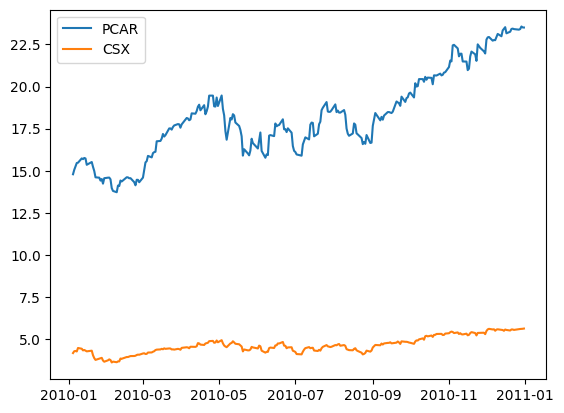

In [5]:
plt.plot(AdjClose_LargeCap.index,AdjClose_LargeCap.loc[:,'PCAR'])
plt.plot(AdjClose_LargeCap.index,AdjClose_LargeCap.loc[:,'CSX'])
plt.legend(['PCAR','CSX'])

<font color=green><h2> 3.1 Cointegration Test </h2></font>

In [6]:
Johansen_Test_Large = coint_johansen(AdjClose_LargeCap.loc[:,['PCAR','CSX']], det_order=0, k_ar_diff=1)
print("Trace statistic:", Johansen_Test_Large.lr1)
print("Critical values (trace test):", Johansen_Test_Large.cvt)
#The johansen test proves that there is a cointegration between the assets PCAR and CSX)
#the other pairs that are above either do not belong to the same sector or the johansen test does not show that there is cointegration


Trace statistic: [17.92948858  0.19524966]
Critical values (trace test): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [7]:
#Weights of assets
Weights_Large=Johansen_Test_Large.evec[:,0]/Johansen_Test_Large.evec[0,0]
Weights_Large
#spread = PCAR-5.16*CSX

array([ 1.        , -5.17190398])

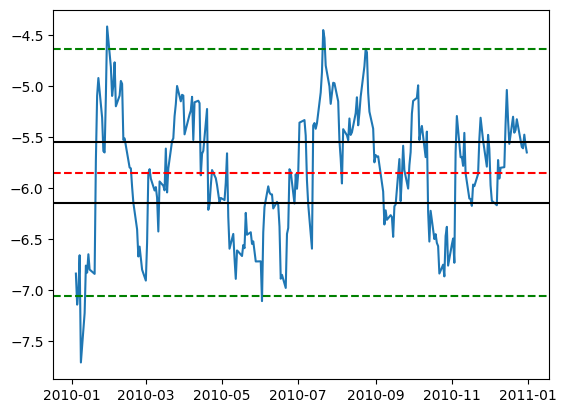

In [8]:
Spread_Large=AdjClose_LargeCap.loc[:,'PCAR']+Weights_Large[1]*AdjClose_LargeCap.loc[:,'CSX']
plt.plot(Spread_Large.index,Spread_Large.values)
plt.axhline(y=np.mean(Spread_Large.values), color='red', linestyle='--')
plt.axhline(y=np.mean(Spread_Large.values)+2*np.std(Spread_Large.values), color='green', linestyle='--')
plt.axhline(y=np.mean(Spread_Large.values)-2*np.std(Spread_Large.values), color='green', linestyle='--')

plt.axhline(y=np.mean(Spread_Large.values)+0.5*np.std(Spread_Large.values), color='black', linestyle='-')
plt.axhline(y=np.mean(Spread_Large.values)-0.5*np.std(Spread_Large.values), color='black', linestyle='-')


<font color=green><h2> 3.2 Cumulative returns </h2></font>

In [14]:
Open_Prices_Large=yf.download(['PCAR','CSX'],Start_date,End_date).loc[:,'Open']
Gain=0
Tactic=0
Prc_Large=[]


for i in range(len(Spread_Large.values)):
    #use a band of 0.5sigma et 2sigma
    if Spread_Large.values[i]>=np.mean(Spread_Large.values)+2*np.std(Spread_Large.values) and Tactic==0:
        Tactic=-1
        sell_price_short_Large=Open_Prices_Large.iloc[i+1,0]
        buy_price_short_Large=Open_Prices_Large.iloc[i+1,1]*np.round(np.abs(Weights_Large[1]))
    if Spread_Large.values[i]<=np.mean(Spread_Large.values)+0.5*np.std(Spread_Large.values) and Tactic==-1:
        Tactic=0
        close_sell_short_Large=Open_Prices_Large.iloc[i+1,0]
        close_buy_short_Large=Open_Prices_Large.iloc[i+1,1]*np.round(np.abs(Weights_Large[1]))
        Profit_short_Large=(sell_price_short_Large-close_sell_short_Large)+(close_buy_short_Large-buy_price_short_Large)
        Pourc_short_Large=Profit_short_Large/(sell_price_short_Large+buy_price_short_Large)
        Prc_Large.append(Pourc_short_Large)
    
    #use a band of -2sigma et -0.5sigma
    if Spread_Large.values[i]<=np.mean(Spread_Large.values)-2*np.std(Spread_Large.values) and Tactic==0:
        Tactic=+1
        buy_price_long_Large=Open_Prices_Large.iloc[i+1,0]
        sell_price_long_Large=Open_Prices_Large.iloc[i+1,1]*np.round(np.abs(Weights_Large[1]))
    if Spread_Large.values[i]>=np.mean(Spread_Large.values)-0.5*np.std(Spread_Large.values) and Tactic==+1:
        Tactic=0
        close_buy_long_Large=Open_Prices_Large.iloc[i+1,0]
        close_sell_long_Large=Open_Prices_Large.iloc[i+1,1]*np.round(np.abs(Weights_Large[1]))
        Profit_long_Large=(close_buy_long_Large-buy_price_long_Large)+(sell_price_long_Large-close_sell_long_Large)
        Pourc_long_Large=Profit_long_Large/(sell_price_long_Large+buy_price_long_Large)
        Prc_Large.append(Pourc_long_Large)

[*********************100%%**********************]  2 of 2 completed


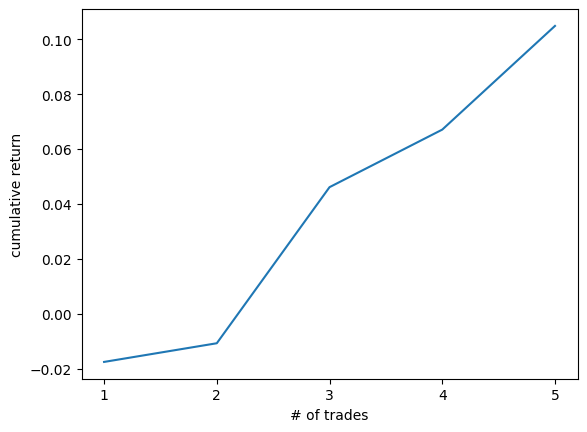

In [15]:
Cumu_return_Large=1
L_cum_Large=[]
for i in Prc_Large:
    Cumu_return_Large=(1+i)*Cumu_return_Large
    L_cum_Large.append(Cumu_return_Large-1)

a=plt.plot(L_cum_Large)
plt.xticks(list(range(len(L_cum_Large))),[str(i) for i in range(1,len(L_cum_Large)+1)])
plt.xlabel('# of trades')
plt.ylabel('cumulative return')
plt.show()

<font color=red><h1> 4. Mid companies</h1></font>

In [14]:
#We choose pairs that belong to the same sector and that have the minimum distance, and in our case it is (MTCH, IAC) (sector=Communication Services)
Pairs_Mid.head(10)

,Ticker2,Sector1,Sector2,distance
Ticker,,,,
MTCH,IAC,Communication Services,Communication Services,0.000019
LBTYK,LBTYA,Communication Services,Communication Services,1.54756
MIDD,ACIW,Industrials,Technology,4.045016
SMTC,MIDD,Technology,Industrials,4.139606
NEOG,MTCH,Healthcare,Communication Services,4.583869
BGC,ACIW,Financial Services,Technology,4.707304
SRCL,AGNC,Industrials,Real Estate,4.732401
WAFD,FORM,Financial Services,Technology,5.02912
WYNN,SHOO,Consumer Cyclical,Consumer Cyclical,5.168521


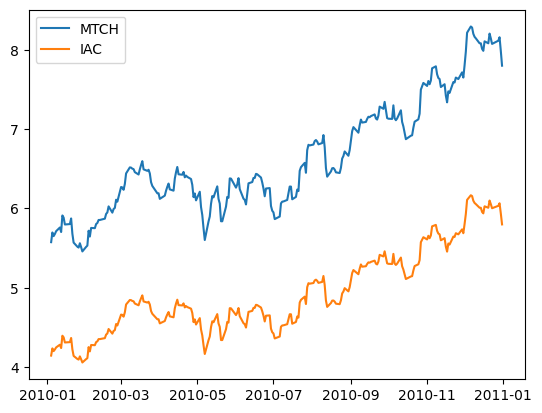

In [15]:
plt.plot(AdjClose_MidCap.index,AdjClose_MidCap.loc[:,'MTCH'])
plt.plot(AdjClose_MidCap.index,AdjClose_MidCap.loc[:,'IAC'])
plt.legend(['MTCH','IAC'])

<font color=green><h2> 4.1 Cointegration Test </h2></font>

In [40]:
Johansen_Test_Mid = coint_johansen(AdjClose_MidCap.loc[:,['MTCH','IAC']], det_order=0, k_ar_diff=1)
print("Trace statistic:", Johansen_Test_Mid.lr1)
print("Critical values (trace test):", Johansen_Test_Mid.cvt)
#The johansen test proves that there is a cointegration between the assets MTCH and IAC)


[*********************100%%**********************]  100 of 100 completed

Trace statistic: [87.295628   1.6934722]
Critical values (trace test): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [41]:
#Weights of assets
Weights_Mid=Johansen_Test_Mid.evec[:,0]/Johansen_Test_Mid.evec[0,0]
Weights_Mid
#spread = MTCH-1.34*IAC

array([ 1.        , -1.34526465])

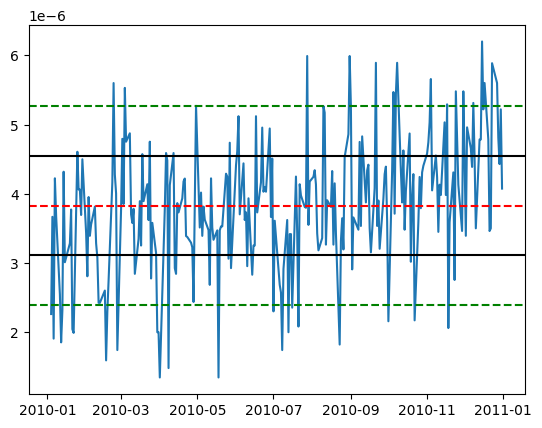

In [42]:
Spread_Mid=AdjClose_MidCap.loc[:,'MTCH']+Weights_Mid[1]*AdjClose_MidCap.loc[:,'IAC']
plt.plot(Spread_Mid.index,Spread_Mid.values)
plt.axhline(y=np.mean(Spread_Mid.values), color='red', linestyle='--')
plt.axhline(y=np.mean(Spread_Mid.values)+1.5*np.std(Spread_Mid.values), color='green', linestyle='--')
plt.axhline(y=np.mean(Spread_Mid.values)-1.5*np.std(Spread_Mid.values), color='green', linestyle='--')

plt.axhline(y=np.mean(Spread_Mid.values)+0.75*np.std(Spread_Mid.values), color='black', linestyle='-')
plt.axhline(y=np.mean(Spread_Mid.values)-0.75*np.std(Spread_Mid.values), color='black', linestyle='-')


<font color=green><h2> 4.2 Cumulative returns </h2></font>

In [ ]:
Open_Prices_Mid=yf.download(['MTCH','IAC'],Start_date,End_date).loc[:,'Open']
Gain=0
Tactic=0

Prc_Mid=[]


for i in range(len(Spread_Mid.values)):
    # Use a band of 0.75sigma et 1.5sigma
    if Spread_Mid.values[i]>=np.mean(Spread_Mid.values)+1.5*np.std(Spread_Mid.values) and Tactic==0:
        Tactic=-1
        sell_price_short=Open_Prices_Mid.iloc[i+1,0]
        buy_price_short=Open_Prices_Mid.iloc[i+1,1]*np.round(np.abs(Weights_Mid[1]))
    if Spread_Mid.values[i]<=np.mean(Spread_Mid.values)+0.75*np.std(Spread_Mid.values) and Tactic==-1:
        Tactic=0
        close_sell_short=Open_Prices_Mid.iloc[i+1,0]
        close_buy_short=Open_Prices_Mid.iloc[i+1,1]*np.round(np.abs(Weights_Mid[1]))
        Profit_short=(sell_price_short-close_sell_short)+(close_buy_short-buy_price_short)
        Pourc_short=Profit_short/(sell_price_short+buy_price_short)
        Prc_Mid.append(Pourc_short)
    
    
    # Use a band of -1.5sigma et -0.75sigma
    if Spread_Mid.values[i]<=np.mean(Spread_Mid.values)-1.5*np.std(Spread_Mid.values) and Tactic==0:
        Tactic=+1
        buy_price_long=Open_Prices_Mid.iloc[i+1,0]
        sell_price_long=Open_Prices_Mid.iloc[i+1,1]*np.round(np.abs(Weights_Mid[1]))
    if Spread_Mid.values[i]>=np.mean(Spread_Mid.values)-0.75*np.std(Spread_Mid.values) and Tactic==+1:
        Tactic=0
        close_buy_long=Open_Prices_Mid.iloc[i+1,0]
        close_sell_long=Open_Prices_Mid.iloc[i+1,1]*np.round(np.abs(Weights_Mid[1]))
        Profit_long=(close_buy_long-buy_price_long)+(sell_price_long-close_sell_long)
        Pourc_long=Profit_long/(sell_price_long+buy_price_long)
        Prc_Mid.append(Pourc_long)

[*********************100%%**********************]  2 of 2 completed


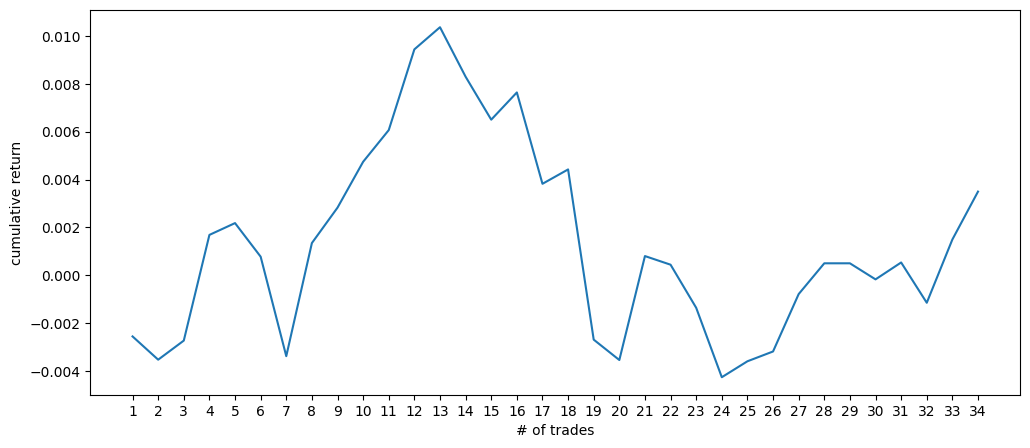

In [83]:
Cumu_return_Mid=1
L_cum_Mid=[]
for i in Prc_Mid:
    Cumu_return_Mid=(1+i)*Cumu_return_Mid
    L_cum_Mid.append(Cumu_return_Mid-1)

plt.figure(figsize=(12,5))
a=plt.plot(L_cum_Mid)

plt.xticks(list(range(len(L_cum_Mid))),[str(i) for i in range(1,len(L_cum_Mid)+1)])

plt.xlabel('# of trades')
plt.ylabel('cumulative return')
plt.show()